# Denoising Autoencoders

In this final lab, we will look at using a denoising autoencoder to remove noise from images. We will use the Fashion MNIST dataset and add noise to the images. We will then train a denoising autoencoder to remove the noise from the images.

Fashion MNIST is a dataset of low resolution images of clothes. It is a popular dataset for image classification and is often used as a drop-in replacement for the original MNIST dataset.

Let's start by loading the dataset and looking at some examples. You'll note that unlike previous labs, we are not even loading the labels! This is because we are going to use the images as both the input and the output of the model.

In [1]:
import tensorflow as tf

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


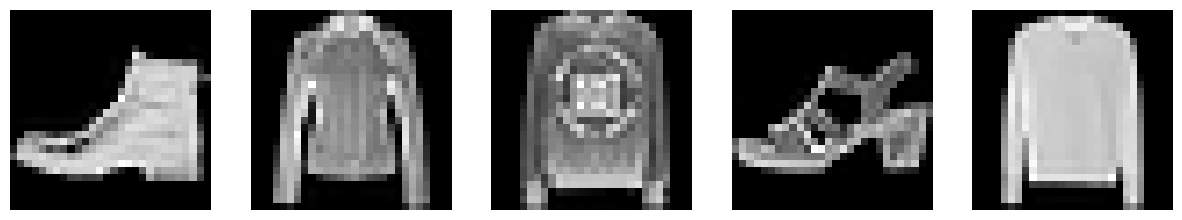

In [2]:
import matplotlib.pyplot as plt
from random import choice

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    ax = axs[i]
    ax.imshow(x_train[choice(range(len(x_train)))], cmap='gray')
    ax.axis('off')

plt.show()

# Adding Noise

Because our model will be trained to remove noise from the images, we need to add noise to the images. We will use a simple method of adding Gaussian noise to the images. We will then clip the values to be between 0 and 1.

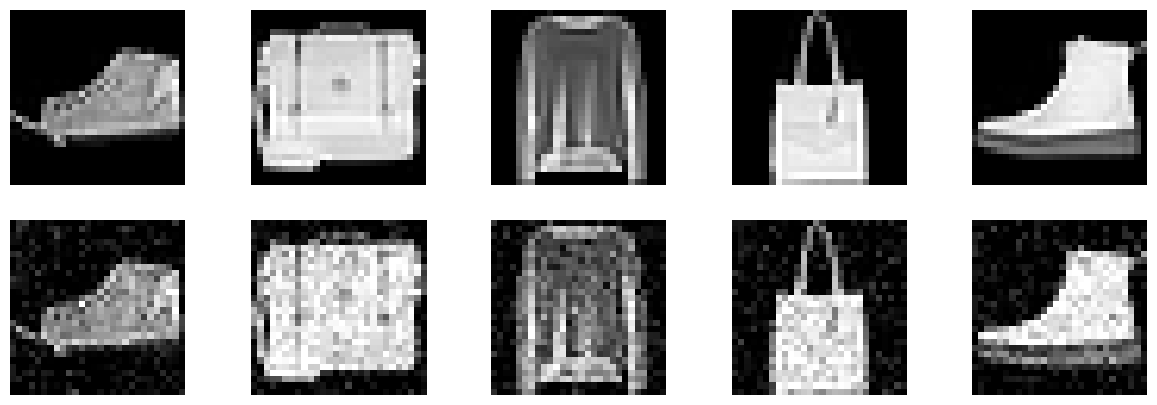

In [3]:
import numpy as np

def add_noise(x, noise_factor=0.1):
    x = x + np.random.normal(loc=0.0, scale=noise_factor, size=x.shape)
    return np.clip(x, 0., 1.)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for i in range(5):
    ax = axs[0, i]
    idx = choice(range(len(x_train)))
    ax.imshow(x_train[idx], cmap='gray')
    ax.axis('off')

    ax = axs[1, i]
    ax.imshow(x_train_noisy[idx], cmap='gray')
    ax.axis('off')

plt.show()

# Building the Model

Now, let's build a simple autoencoder. This type of model is comprised of two main parts: the encoder and the decoder. The encoder will compress the input image into a lower dimensional representation, and the decoder will attempt to recreate the original image from this lower dimensional representation.

We have completed the encoder for you. It is a simple model that flattens the input image and then passes it through two dense layers. The decoder is your task to complete. It should take the output of the encoder and attempt to recreate the original image.

**Note:** we are used to squashing the output of our model to be between 0 and 1, either with softmax or sigmoid depending on the use case. However, this should not apply to the output of our encoder! The encoder is not outputting a probability, but rather a representation of the input. As such, we should use an activation function like `relu` for the dense layers of the encoder. The decoder, however, should use `sigmoid` to squash the output to be between 0 and 1.

In [5]:
from tensorflow.keras import layers, models

encoder = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu')
])

decoder = models.Sequential([
    # Add layers to accept the output of the encoder and attempt to recreate the original image.
    # The layers should be the reverse of the encoder.
    layers.Dense(128, activation='relu'),
    layers.Dense(784, activation='sigmoid'),
    layers.Reshape((28, 28))
])

autoencoder = models.Sequential([
    encoder,
    decoder
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We will use binary cross-entropy as the loss function, as we are treating the model as a simple logistic regression model. We will use the Adam optimizer to train the model.

In [6]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 64)             │       108,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 28, 28)         │       109,456 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,192 (852.31 KB)

 Trainable params: 218,192 (852.31 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Special callback to visualize the training progress
from tensorflow.keras.callbacks import Callback

def plot_image(i):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    axs[0].imshow(x_test[i], cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(x_test_noisy[i], cmap='gray')
    axs[1].set_title('Noisy')
    axs[1].axis('off')

    axs[2].imshow(autoencoder.predict(x_test_noisy[[i]])[0], cmap='gray')
    axs[2].set_title('De-noised')
    axs[2].axis('off')

    plt.show()

class VisualizeCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        plot_image(3)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(patience=5, monitor='val_loss'),
        ModelCheckpoint('autoencoder.keras', save_best_only=True)
    ]
)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4089 - val_loss: 0.3070
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3011 - val_loss: 0.2959
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2915 - val_loss: 0.2905
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2873 - val_loss: 0.2873
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2842 - val_loss: 0.2847
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2807 - val_loss: 0.2829
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2801 - val_loss: 0.2815
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2794 - val_loss: 0.2807
Epoch 9/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2778 - val_loss: 0.2797
Epoch 10/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2766 - val_loss: 0.2789
Epoch 11/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2757 - val_loss: 0.2784
Epoch 12/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [11]:
# Load the best model

autoencoder = models.load_model('autoencoder.keras')

# Evaluating the Model

Now that we have trained the model, let's see how well it can remove noise from the images. Use the `plot_image` method to visualize the original images, the noisy images, and the denoised images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


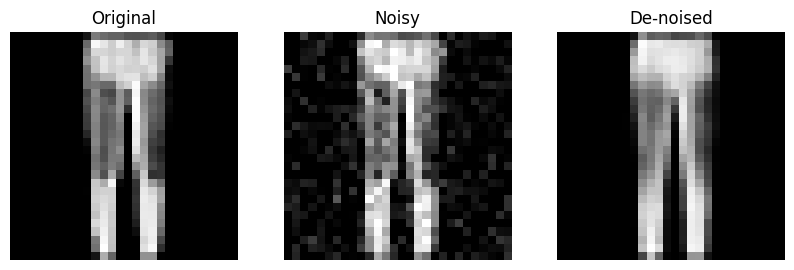

In [12]:
plot_image(3)

# Using Autoencoders for Dimensionality Reduction

During the course, we've looked at standard techniques for dimensionality reduction - PCA and t-SNE. We can also use autoencoders for dimensionality reduction. The output of our encoder is a lower-dimensional representation of the input, which is used by the decoder to recreate that input. As a result, we can use just the encoder to get a low-dimensional representation of our input data.

In the code below, modify your encoder and decoder so that the encoder outputs a 2-dimensional representation of the input. For this task, we won't use the noisy images to train, since our priority now is creating an accurate representation of the original images. This time we will also work with the labels, but only to visualize the data in 2D.

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [15]:
encoder = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    # Add layers to compress the input image into a 2-dimensional representation
    layers.Dense(2, activation=None)
])

decoder = models.Sequential([
    # Add layers to accept the 2-dimensional representation and attempt to recreate the original image.
    layers.Dense(128, activation='relu'),
    layers.Dense(784, activation='sigmoid'),
    layers.Reshape((28, 28))
])

autoencoder = models.Sequential([
    encoder,
    decoder
])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(patience=5, monitor='val_loss'),
        ModelCheckpoint('autoencoder.keras', save_best_only=True)
    ]
)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4889 - val_loss: 0.3637
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3537 - val_loss: 0.3496
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3454 - val_loss: 0.3464
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3420 - val_loss: 0.3448
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3408 - val_loss: 0.3437
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3399 - val_loss: 0.3427
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3396 - val_loss: 0.3419
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3385 - val_loss: 0.3414
Epoch 9/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3374 - val_loss: 0.3410
Epoch 10/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3378 - val_loss: 0.3408
Epoch 11/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3379 - val_loss: 0.3403
Epoch 12/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [18]:
autoencoder = models.load_model('autoencoder.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


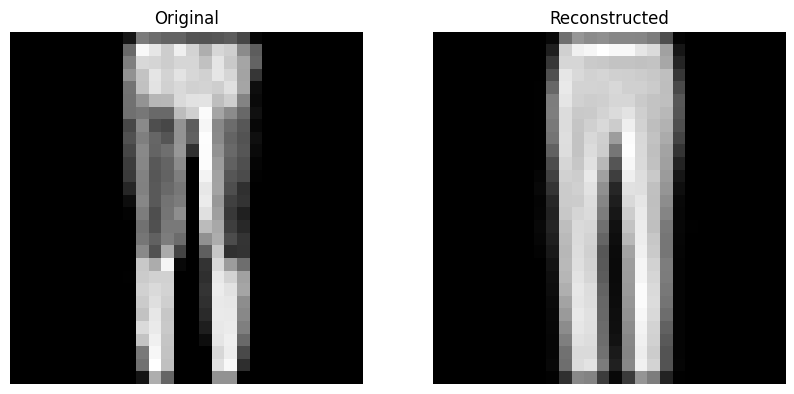

In [19]:
# Visualize reconstruction
def plot_reconstruction(i):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(x_test[i], cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(autoencoder.predict(x_test[[i]])[0], cmap='gray')
    axs[1].set_title('Reconstructed')
    axs[1].axis('off')

    plt.show()

plot_reconstruction(3)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


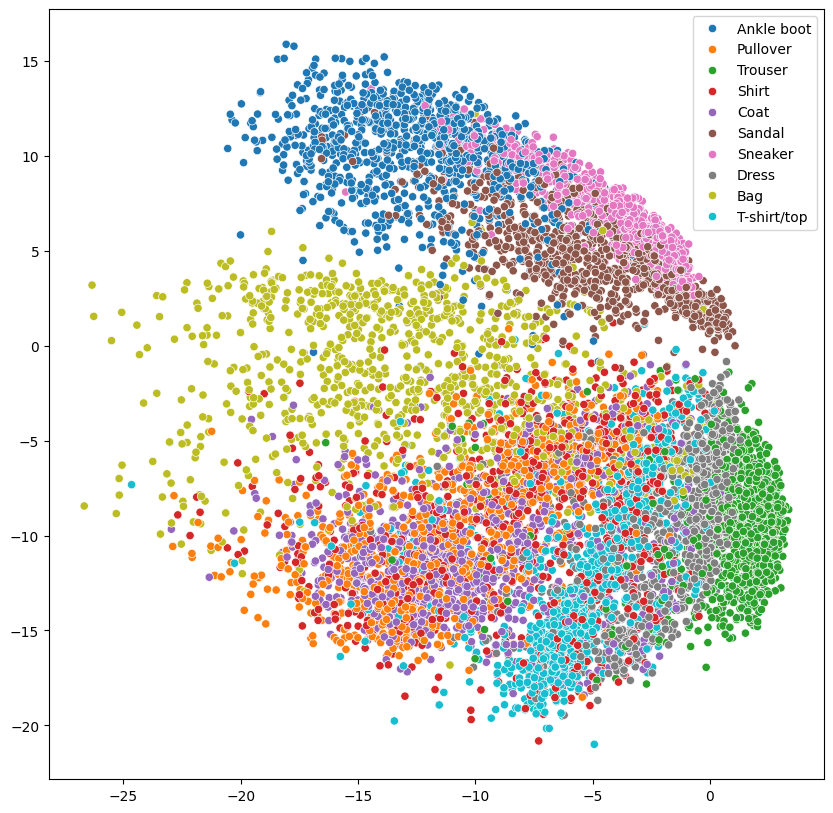

In [20]:
import seaborn as sns

encoded = encoder.predict(x_test)

labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

plt.figure(figsize=(10, 10))
sns.scatterplot(x=encoded[:, 0], y=encoded[:, 1], hue=[labels[i] for i in y_test], palette='tab10')
plt.show()

# Exercises

1. In the first part of the lab, we added Gaussian noise to the images. You can add different types of noise - take a look at some of the options available in numpy [here](https://numpy.org/doc/stable/reference/random/) and try adding different types of noise to the images. How does this affect the performance of the autoencoder?

2. In the second part of the lab, we used the encoder to create a 2-dimensional representation of the input data. We then visualized this representation using a scatter plot. You can also use 3 dimensions instead of 2. How does this affect the reconstruction error? Use the code below to visualize 3D data.

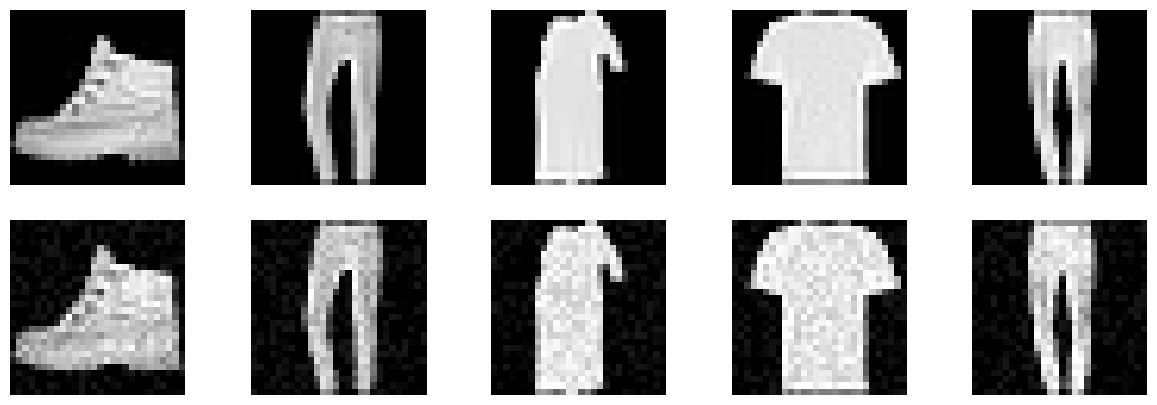

In [21]:
def add_noise(x, noise_factor=0.1):
    x = x + np.random.uniform(low=-noise_factor, high=noise_factor, size=x.shape)
    return np.clip(x, 0., 1.)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for i in range(5):
    ax = axs[0, i]
    idx = choice(range(len(x_train)))
    ax.imshow(x_train[idx], cmap='gray')
    ax.axis('off')

    ax = axs[1, i]
    ax.imshow(x_train_noisy[idx], cmap='gray')
    ax.axis('off')

plt.show()

In [22]:
encoder = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu')
])

decoder = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(784, activation='sigmoid'),
    layers.Reshape((28, 28))
])

autoencoder = models.Sequential([
    encoder,
    decoder
])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(patience=5, monitor='val_loss'),
        ModelCheckpoint('autoencoder.keras', save_best_only=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4070 - val_loss: 0.3072
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3002 - val_loss: 0.2950
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2912 - val_loss: 0.2891
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2853 - val_loss: 0.2867
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2823 - val_loss: 0.2832
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2800 - val_loss: 0.2815
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2785 - val_loss: 0.2802
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2776 - val_loss: 0.2794
Epoch 9/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2765 - val_loss: 0.2781
Epoch 10/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2749 - val_loss: 0.2772
Epoch 11/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2745 - val_loss: 0.2764
Epoch 12/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [23]:
autoencoder = models.load_model('autoencoder.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


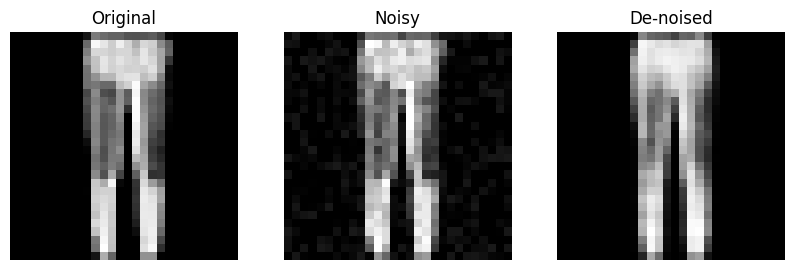

In [24]:
# Visualize the original, uniform noisy, and denoised images to evaluate the autoencoder's performance with uniform noise
plot_image(3)

## Impact of Uniform Noise

Adding uniform noise results in a different visual appearance compared to Gaussian noise. Instead of a subtle grainy texture, the uniform noise creates a more blocky or pixelated effect across the image, with distinct bright and dark spots uniformly distributed.

The autoencoder appears to be less effective at removing uniform noise compared to Gaussian noise. The denoised image still retains a noticeable amount of the uniform noise pattern. This suggests that the autoencoder, as currently structured, might be better suited for handling the characteristics of Gaussian noise.

## Experiment with 3-dimensional dimensionality reduction


In [26]:
encoder = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation=None) # Modified to output 3 dimensions
])

decoder = models.Sequential([
    layers.Dense(128, activation='relu'), # First layer accepts input of size 3
    layers.Dense(784, activation='sigmoid'),
    layers.Reshape((28, 28))
])

autoencoder = models.Sequential([
    encoder,
    decoder
])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)      │ (None, 3)              │       100,867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 28, 28)         │       101,648 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,515 (791.07 KB)

 Trainable params: 202,515 (791.07 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(patience=5, monitor='val_loss'),
        ModelCheckpoint('autoencoder.keras', save_best_only=True)
    ]
)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4276 - val_loss: 0.3338
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3265 - val_loss: 0.3236
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3192 - val_loss: 0.3196
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3153 - val_loss: 0.3177
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3146 - val_loss: 0.3160
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3132 - val_loss: 0.3153
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3123 - val_loss: 0.3144
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3110 - val_loss: 0.3139
Epoch 9/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3115 - val_loss: 0.3134
Epoch 10/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3110 - val_loss: 0.3129
Epoch 11/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3103 - val_loss: 0.3125
Epoch 12/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


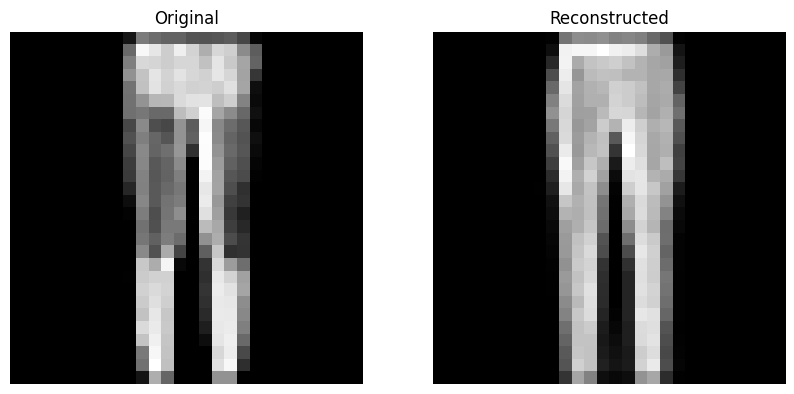

In [28]:
# Load the best model with 3D latent space

autoencoder = models.load_model('autoencoder.keras')

# Visualize reconstruction with 3D latent space
plot_reconstruction(3)

In [29]:
# Encode the test data using the encoder model
encoded = encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [31]:
import plotly.express as px
import numpy as np # Import numpy as it's used in the function

def plot_3d_reconstruction(i):
    fig = px.scatter_3d(
        x=encoded[:, 0], y=encoded[:, 1], z=encoded[:, 2],
        color=[labels[i] for i in y_test]
    )
    fig.show()

In [32]:
# Visualize the 3D encoded data
plot_3d_reconstruction(3)

## Impact of 3-dimensional dimensionality reduction

Compared to the 2-dimensional visualization, the 3-dimensional scatter plot provides a more spread out view of the data. This can potentially reveal better separation between some of the classes that were overlapping in 2D.

A 3-dimensional representation can capture more complex patterns and variations in the data compared to a 2-dimensional one, allowing the decoder to reconstruct the original image with greater fidelity.